# VOSK Speech Recognition Feature Extraction

|Category(ies)         |References            |Input Type            |Workflows             |Next Steps            |
|----------------------|----------------------|----------------------|----------------------|----------------------|
|feature extraction|[dps repo](https://github.com/jdchart/dps)|results of a speech recognition anlysis|||

In this notebook, we'll take a "raw" speech recognition analysis of an audio file, and extract a number of different features from it. Many of these features we're developed in the context of Théo Heugebaert's PhD on rhythm in the performing arts, and are part of the [dps python package](https://github.com/jdchart/dps.git) which was designed for his project.

## 1. Setup
First, let's import all of the various packages that we'll need.

In [2]:
# Installs
import sys
!echo "Purging pip environment and installing packages..."
!{sys.executable} -m pip cache purge 
!{sys.executable} -m pip uninstall -y jlu 
!{sys.executable} -m pip install -q git+https://github.com/arvest-data-in-context/jlu 
!{sys.executable} -m pip uninstall -y dps
!{sys.executable} -m pip install -q git+https://github.com/jdchart/dps.git

# Imports
print("Importing packages...")
import os
import jlu
import dps
import matplotlib.pyplot as plt
import numpy as np
print("Ready!")

"Purging pip environment and installing packages..."
Files removed: 0


Found existing installation: jlu 0.0.1
Uninstalling jlu-0.0.1:
  Successfully uninstalled jlu-0.0.1
Found existing installation: dps 0.0.1
Uninstalling dps-0.0.1:
  Successfully uninstalled dps-0.0.1
Importing packages...
Ready!


## 2. Load VOSK Analysis
Here we shall load the json output of the VOSK analyses we wish to process. Note that this notebook is specifically tailored to extract features from the VOSK speech recognition notebook in this collection of notebooks, however it wouldn't take much to adjust it for the output of another speech recognition model. Change the `VOSK_ANALYSES` variable to the folder that contains the analyses you wish to process.

In [3]:
VOSK_ANALYSES = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\operate1curve"
analysis_files = jlu.files.collect_files(VOSK_ANALYSES, ["json"])
print(analysis_files)

['C:\\Users\\theoh\\Documents\\Fac\\Thèse\\Donnees\\DPS_LMI\\Fusion\\operate1curve\\LMI_20230509_0_9452.16_final_mergedlength.json']


## 3. Feature Extraction [V1]
Now we can use the [dps python package](https://github.com/jdchart/dps.git) to extract the various features. We shall do this for each file.

Before we process everything, let's just take a closer look at one instance in order to understand what's happening under the hood.

In [3]:
# First we load the analysis file in the dps.SpeechAnalysis() class
speech_recognition = dps.SpeechAnalysis(analysis_files[4], fps = 32)

dps_curve = speech_recognition.get_dps_feature_curve(1920, 20)

# This will have already parsed the data into a raw curve which can be visualized:
#speech_recognition.display_raw_curve(0)
#speech_recognition.display_raw_curve(1)

IndexError: list index out of range

Note that each feature has a number of different parameters. You can extract as many features as you wish, with varying different parameters.

Now we can extract features like dps as follows:

In [1]:
plt.figure(figsize=(10, 6))

# Créer les numéros de frame et convertir en temps (MM.SS)
frame_numbers = np.arange(len(dps_curve))
fps = 32  # Frame rate utilisé dans `speech_recognition`
times_in_seconds = frame_numbers / fps  # Conversion des frames en secondes

# Formater les étiquettes en MM.SS
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

# Tracer la courbe
plt.plot(times_in_seconds, dps_curve, drawstyle='steps-post')
#plt.plot(times_in_seconds, speech_recognition.raw_curve[0], drawstyle='steps-post')
plt.xlabel('Time (MM:SS)')
plt.ylabel('DPS')
plt.title('DPS Curve')

# Ajuster les étiquettes de l'axe des x
plt.xticks(
    ticks=times_in_seconds[::fps * 300],  # Un tick toutes les 30 secondes
    labels=[format_time(t) for t in times_in_seconds[::fps * 300]],
    rotation=45,  # Inclinaison des étiquettes
    ha='right'    # Alignement
)

plt.show()


NameError: name 'plt' is not defined

## 4. Feature Extraction Selfmade
Now we can use the [dps python package](https://github.com/jdchart/dps.git) to extract the various features. We shall do this for each file.

Before we process everything, let's just take a closer look at one instance in order to understand what's happening under the hood.

In [4]:
# Charger toutes les courbes DPS à partir des fichiers JSON
all_dps_curves = {}  # Dictionnaire pour stocker les courbes avec leurs noms

setup_window = 96  # Paramètre `setup_window`
hop_size = 4        # Paramètre `hop_size`

print(f"Processing {len(analysis_files)} JSON files...")

for file in analysis_files:
    # Charger le fichier d'analyse
    speech_recognition = dps.SpeechAnalysis(file, fps=32)
    
    # Calculer la courbe DPS
    dps_curve = speech_recognition.get_dps_feature_curve(setup_window, hop_size)
    
    # Extraire le nom du fichier pour l'utiliser comme clé
    file_name = os.path.basename(file)
    
    # Stocker la courbe
    all_dps_curves[file_name] = dps_curve

print(f"Processed {len(all_dps_curves)} files.")


Processing 1 JSON files...
Processed 1 files.


In [5]:
import pandas as pd

# Recharger le CSV du chronométrage manuel
stopwatch_csv_path = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\operate1curve\LMI_Stopwatch_20230509.csv"
df_stopwatch = pd.read_csv(stopwatch_csv_path, decimal=',')


In [6]:
# Choisir un fichier ASR (si tu en as plusieurs, adapte ici)
file_name_asr = list(all_dps_curves.keys())[0]
dps_curve = all_dps_curves[file_name_asr]
fps = 32  # fréquence d'échantillonnage en frames par seconde

# Créer les coordonnées x et y pour une courbe "en paliers" depuis l'ASR mais selon les timestamps stopwatch
x_asr_on_manual = []
y_asr_on_manual = []

for _, row in df_stopwatch.iterrows():
    start_frame = int(row['start_time_s'] * fps)
    end_frame = int(row['end_time_s'] * fps)
    segment = dps_curve[start_frame:end_frame]

    mean_val = np.mean(segment) if len(segment) > 0 else np.nan

    # Ajouter au format "escalier"
    x_asr_on_manual.extend([row['start_time_s'], row['end_time_s']])
    y_asr_on_manual.extend([mean_val, mean_val])


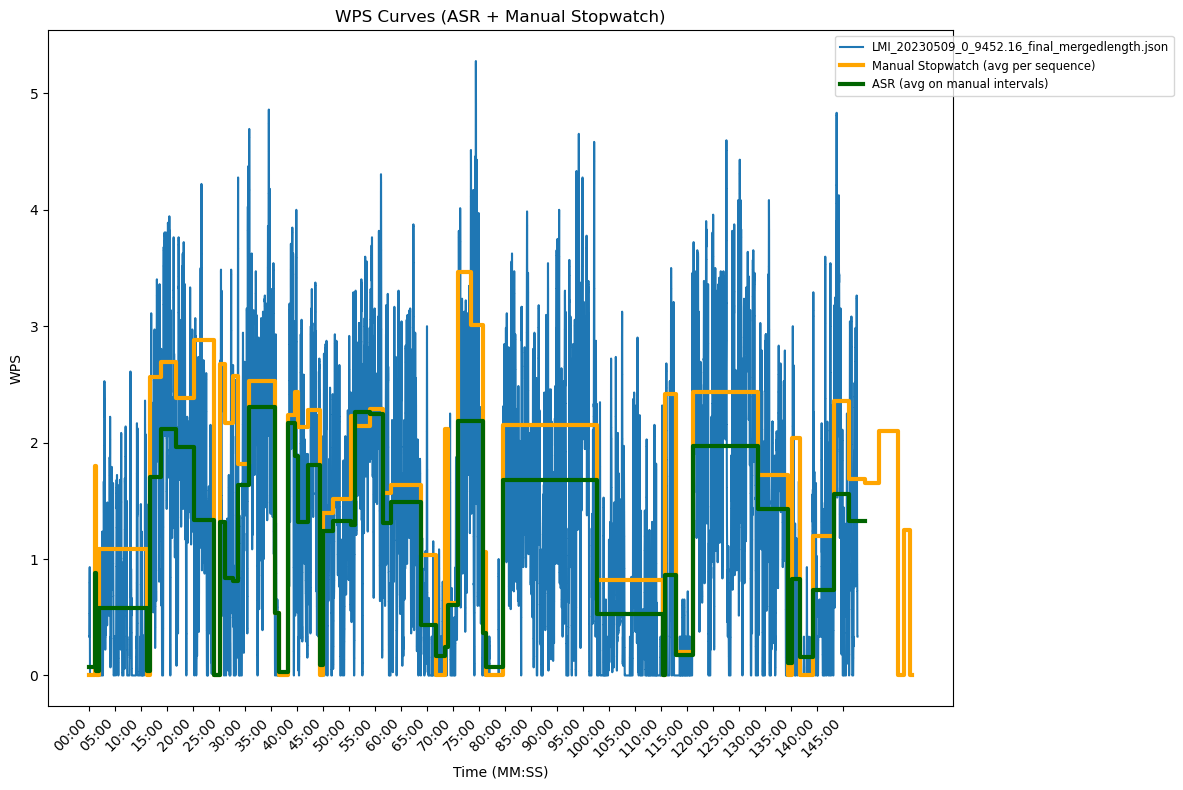

In [7]:
# Créer les coordonnées x et y pour une courbe "en paliers"
x_manual = []
y_manual = []

for _, row in df_stopwatch.iterrows():
    x_manual.extend([row['start_time_s'], row['end_time_s']])
    y_manual.extend([row['wps_mean'], row['wps_mean']])

# Afficher les courbes sur un seul graphique
plt.figure(figsize=(12, 8))

fps = 32  # Frame rate utilisé dans `speech_recognition`

# Courbes ASR
for file_name, dps_curve in all_dps_curves.items():
    frame_numbers = np.arange(len(dps_curve))
    times_in_seconds = frame_numbers / fps
    plt.plot(times_in_seconds, dps_curve, label=file_name, drawstyle='steps-post')

# Courbe stopwatch en "paliers"
plt.plot(x_manual, y_manual, label='Manual Stopwatch (avg per sequence)', color='orange', linewidth=3, linestyle='-')

# Étiquettes et axes
plt.xlabel('Time (MM:SS)')
plt.ylabel('WPS')
plt.title('WPS Curves (ASR + Manual Stopwatch)')
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

plt.xticks(
    ticks=np.arange(0, max(times_in_seconds), 300),
    labels=[format_time(t) for t in np.arange(0, max(times_in_seconds), 300)],
    rotation=45,
    ha='right'
)

# Courbe ASR alignée sur les timestamps du chronométrage
plt.plot(x_asr_on_manual, y_asr_on_manual, label='ASR (avg on manual intervals)', color='darkgreen', linewidth=3, linestyle='-')


plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), fontsize='small')
plt.tight_layout()
plt.show()


In [8]:
print(f"{'LMI_20230509_0_9452.16_final_mergedlength.json'} — Length: {len(dps_curve)}, Duration: {len(dps_curve) / fps:.2f} seconds")


LMI_20230509_0_9452.16_final_mergedlength.json — Length: 283564, Duration: 8861.38 seconds


In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Charger le JSON contenant les résultats de Vosk
with open(r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\operate1curve\LMI_20230509_0_9452.16_final_mergedlength.json", encoding='utf-8') as f:
    data = json.load(f)

# Extraire les mots reconnus avec leurs timestamps
words = [w for w in data["result"] if "start" in w and "end" in w]

# Déterminer la durée totale d'analyse
end_time_total = max(w["end"] for w in words)
print(f"Durée totale détectée via JSON : {end_time_total:.2f} secondes")

# Paramètres de la fenêtre glissante
window_size = 30.0  # taille de la fenêtre en secondes
hop_size = 1.0     # pas de déplacement entre les fenêtres

# Génération des fenêtres
times = np.arange(0, end_time_total, hop_size)
wps_curve = []

# Calcul WPS : nombre de mots par seconde dans chaque fenêtre
for t in times:
    count = sum(1 for w in words if t <= w["start"] < t + window_size)
    wps = count / window_size
    wps_curve.append(wps)

wps_curve = np.array(wps_curve)


Durée totale détectée via JSON : 9452.16 secondes


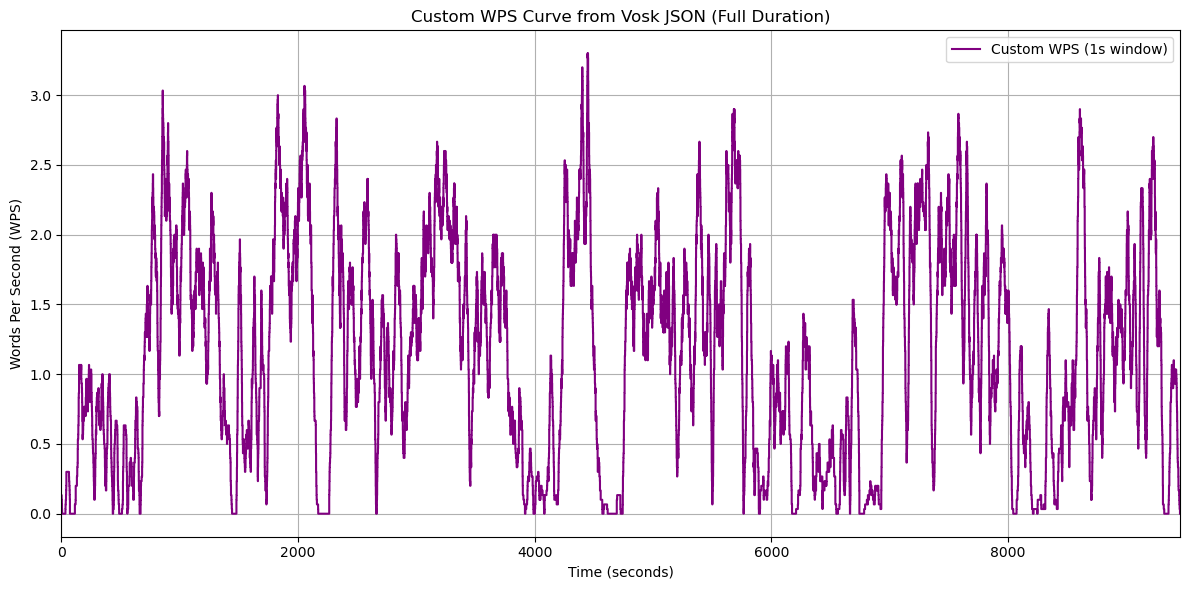

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(times, wps_curve, drawstyle='steps-post', label="Custom WPS (1s window)", color="purple")

plt.title("Custom WPS Curve from Vosk JSON (Full Duration)")
plt.xlabel("Time (seconds)")
plt.ylabel("Words Per Second (WPS)")
plt.grid(True)
plt.xlim(0, end_time_total)
plt.tight_layout()
plt.legend()
plt.show()


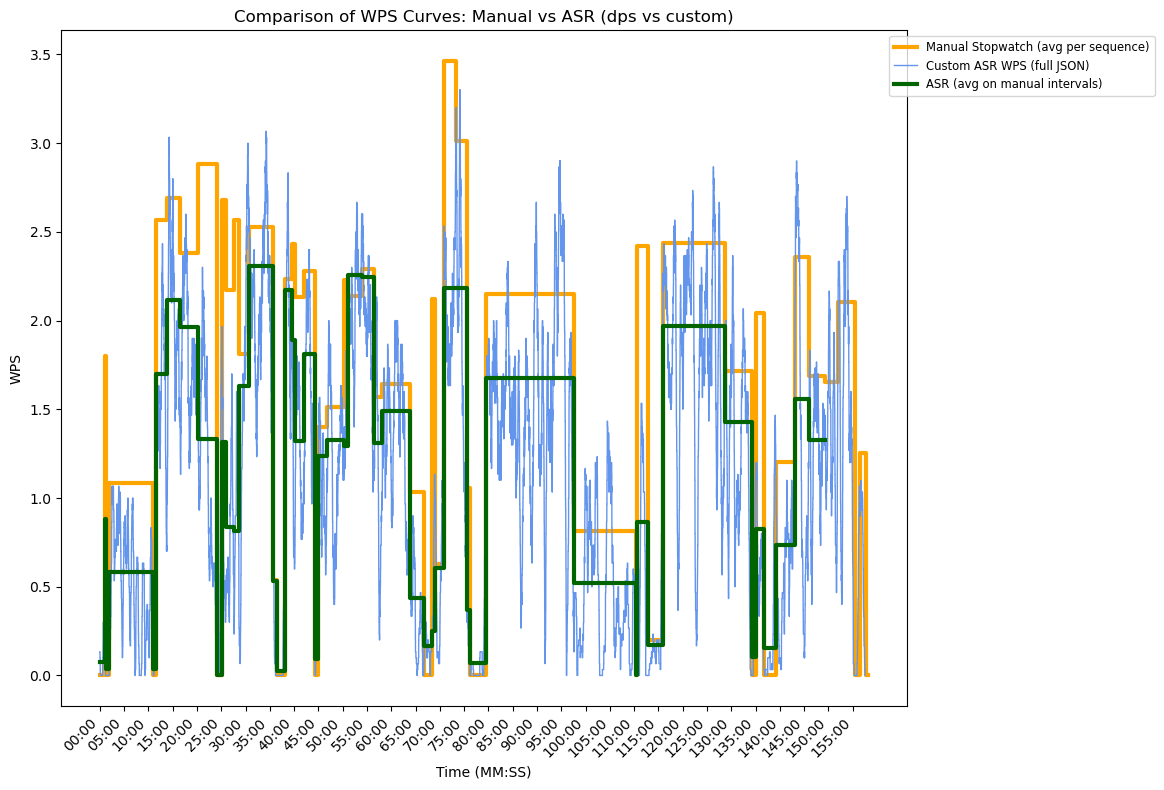

In [11]:
# Nouvelle courbe ASR complète (recalculée manuellement)
plt.figure(figsize=(12, 8))

'''# Courbe ASR classique (incomplète)
for file_name, dps_curve in all_dps_curves.items():
    frame_numbers = np.arange(len(dps_curve))
    times_in_seconds = frame_numbers / fps
    plt.plot(times_in_seconds, dps_curve, label='ASR via dps (truncated)', drawstyle='steps-post', color='cornflowerblue')'''

# Courbe manuelle en paliers
plt.plot(x_manual, y_manual, label='Manual Stopwatch (avg per sequence)', color='orange', linewidth=3, linestyle='-')

# Courbe ASR complète recalculée manuellement
plt.plot(times, wps_curve, label='Custom ASR WPS (full JSON)', drawstyle='steps-post', color='cornflowerblue', linewidth=1)

# Courbe ASR alignée sur les timestamps du chronométrage
plt.plot(x_asr_on_manual, y_asr_on_manual, label='ASR (avg on manual intervals)', color='darkgreen', linewidth=3, linestyle='-')

# Axe X en MM:SS
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

max_time = max(times[-1], max(times_in_seconds))  # pour s'adapter à la plus longue des courbes
plt.xticks(
    ticks=np.arange(0, max_time, 300),  # un tick toutes les 5 min
    labels=[format_time(t) for t in np.arange(0, max_time, 300)],
    rotation=45,
    ha='right'
)

# Titres et légende
plt.xlabel('Time (MM:SS)')
plt.ylabel('WPS')
plt.title('Comparison of WPS Curves: Manual vs ASR (dps vs custom)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize='small')
plt.tight_layout()
plt.show()


In [12]:
# Recalcul des moyennes d'ASR sur les intervalles de la méthode manuelle
x_asr_on_manual = []
y_asr_on_manual = []

for _, row in df_stopwatch.iterrows():
    start = row['start_time_s']
    end = row['end_time_s']

    # Indices correspondant à ces temps dans la série `times`
    mask = (times >= start) & (times < end)
    segment_values = wps_curve[mask]

    if len(segment_values) > 0:
        avg_wps = segment_values.mean()
    else:
        avg_wps = np.nan  # ou 0, selon ce que tu veux

    # Pour courbe en paliers
    x_asr_on_manual.extend([start, end])
    y_asr_on_manual.extend([avg_wps, avg_wps])


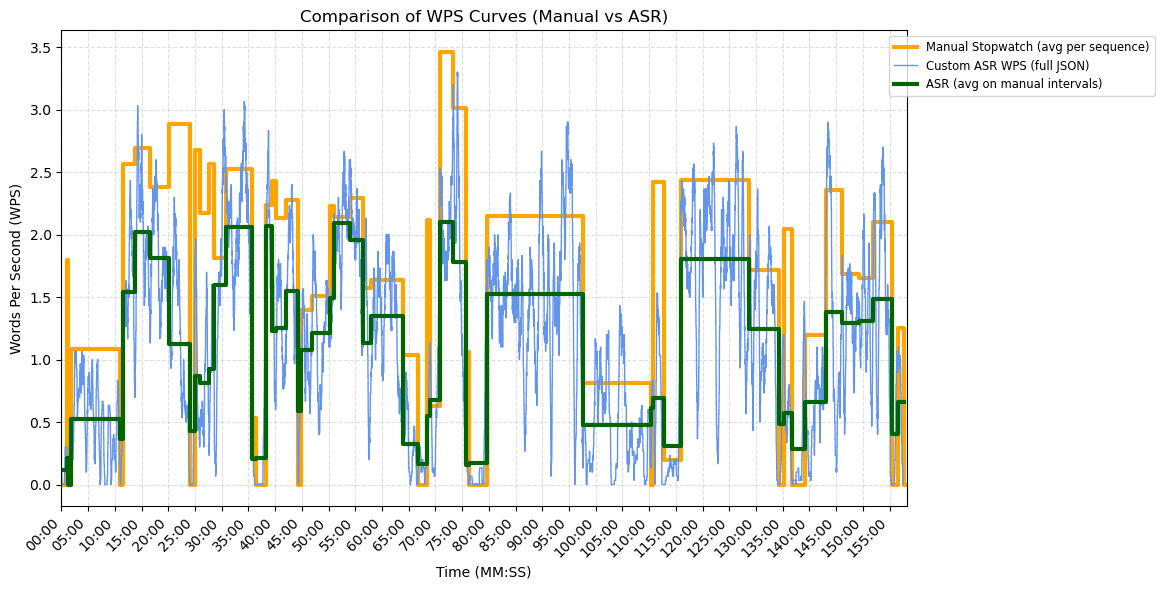

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Courbe manuelle en paliers
plt.plot(x_manual, y_manual, label='Manual Stopwatch (avg per sequence)',
         color='orange', linewidth=3, linestyle='-')

# Courbe ASR complète recalculée manuellement
plt.plot(times, wps_curve, label='Custom ASR WPS (full JSON)',
         drawstyle='steps-post', color='cornflowerblue', linewidth=1)

# Courbe ASR alignée sur les timestamps du chronométrage
plt.plot(x_asr_on_manual, y_asr_on_manual, label='ASR (avg on manual intervals)',
         color='darkgreen', linewidth=3, linestyle='-')

# Axe X : format MM:SS
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

max_time = max(times[-1], max(x_manual), max(x_asr_on_manual))
plt.xticks(
    ticks=np.arange(0, max_time, 300),
    labels=[format_time(t) for t in np.arange(0, max_time, 300)],
    rotation=45,
    ha='right'
)

# Habillage
plt.title("Comparison of WPS Curves (Manual vs ASR)")
plt.xlabel("Time (MM:SS)")
plt.ylabel("Words Per Second (WPS)")
plt.grid(True, axis='both', linestyle='--', alpha=0.4)
plt.xlim(0, max_time)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize='small')
plt.tight_layout()
plt.show()


In [14]:
diffs = []

for _, row in df_stopwatch.iterrows():
    start = row['start_time_s']
    end = row['end_time_s']
    wps_manual = row['wps_mean']

    # Trouver les points ASR dans cet intervalle
    mask = (times >= start) & (times < end)
    segment = np.array(wps_curve)[mask]

    wps_asr = segment.mean() if len(segment) > 0 else np.nan
    difference = wps_asr - wps_manual if not np.isnan(wps_asr) else np.nan

    diffs.append({
        "segment": int(row.name),
        "start_time_s": start,
        "end_time_s": end,
        "wps_manual": wps_manual,
        "wps_asr": wps_asr,
        "diff": difference
    })


In [15]:
import pandas as pd

# Création du DataFrame
df_diffs = pd.DataFrame(diffs)

# Sauvegarde CSV
csv_path = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\operate1curve\WPS_Comparison_Stopwatch_ASR.csv"
df_diffs.to_csv(csv_path, index=False)
print(f"✅ Fichier exporté à : {csv_path}")

# Corrélation
correlation = df_diffs[['diff','wps_asr']].dropna().corr().iloc[0,1]
print(f"📊 Corrélation entre wps_manual et différence (ASR - Stopwatch) : {correlation:.3f}")


✅ Fichier exporté à : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\operate1curve\WPS_Comparison_Stopwatch_ASR.csv
📊 Corrélation entre wps_manual et différence (ASR - Stopwatch) : -0.258


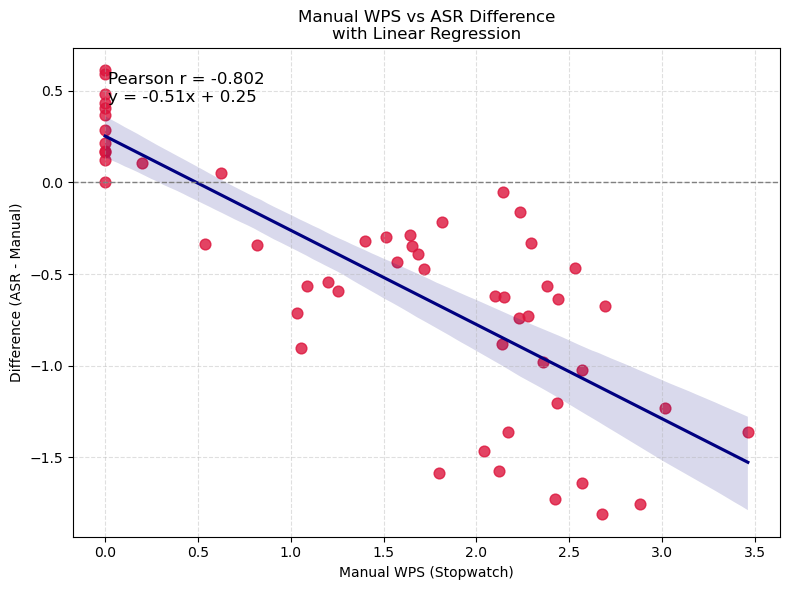

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Nettoyer les valeurs manquantes
df_corr = df_diffs.dropna(subset=["wps_manual", "diff"])

# Calcul de la régression linéaire
slope, intercept, r_value, p_value, std_err = linregress(df_corr["wps_manual"], df_corr["diff"])
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"

# Plot avec ligne de régression
plt.figure(figsize=(8, 6))
sns.regplot(data=df_corr, x="wps_manual", y="diff", color="crimson", scatter_kws={"s": 60}, line_kws={"color": "navy"})

# Ligne horizontale à y = 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Titre et axes
plt.xlabel("Manual WPS (Stopwatch)")
plt.ylabel("Difference (ASR - Manual)")
plt.title("Manual WPS vs ASR Difference\nwith Linear Regression")

# Annoter la corrélation et l'équation
plt.text(0.05, 0.95, f"Pearson r = {r_value:.3f}\n{line_eq}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


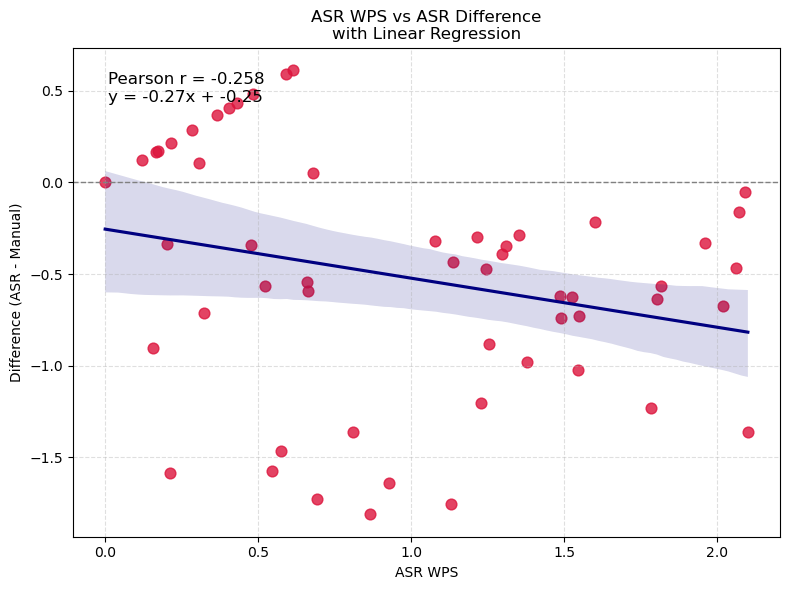

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Nettoyer les valeurs manquantes
df_corr = df_diffs.dropna(subset=["wps_asr", "diff"])

# Calcul de la régression linéaire
slope, intercept, r_value, p_value, std_err = linregress(df_corr["wps_asr"], df_corr["diff"])
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"

# Plot avec ligne de régression
plt.figure(figsize=(8, 6))
sns.regplot(data=df_corr, x="wps_asr", y="diff", color="crimson", scatter_kws={"s": 60}, line_kws={"color": "navy"})

# Ligne horizontale à y = 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Titre et axes
plt.xlabel("ASR WPS")
plt.ylabel("Difference (ASR - Manual)")
plt.title("ASR WPS vs ASR Difference\nwith Linear Regression")

# Annoter la corrélation et l'équation
plt.text(0.05, 0.95, f"Pearson r = {r_value:.3f}\n{line_eq}",
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


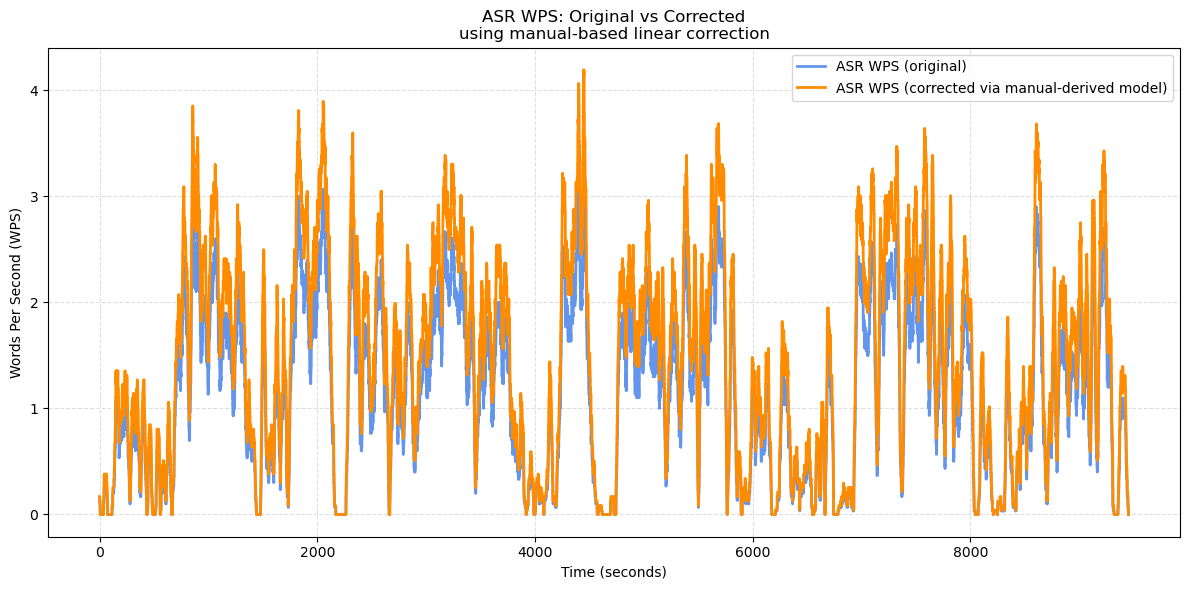

In [35]:
plt.figure(figsize=(12, 6))

# Courbe ASR originale
plt.plot(times, wps_curve, drawstyle='steps-post', label="ASR WPS (original)", color="cornflowerblue", linewidth=2)

# Correction : ajouter la différence estimée via l’équation de corrélation avec manual
# Equation : diff = 0.51 * wps_asr + 0.25
diff_estimated = 0.27 * wps_curve 
wps_curve_corrected = wps_curve + diff_estimated

# Courbe corrigée
plt.plot(times, wps_curve_corrected, drawstyle='steps-post', label="ASR WPS (corrected via manual-derived model)", color="darkorange", linewidth=2)

# Mise en forme
plt.title("ASR WPS: Original vs Corrected\nusing manual-based linear correction")
plt.xlabel("Time (seconds)")
plt.ylabel("Words Per Second (WPS)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


Analyse différence de dps stopwatch et asr

## 5. Clustering

Dans les prochaines cellules nous allons procéder à une première visualisation via clustering et afficher un graph présentant les trois clusters et un affichant le centre de chacun des clusters

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Préparation des données pour le clustering
print("Preparing data for clustering...")

# Fixer une longueur commune pour toutes les courbes (échantillonnage à 1000 points par exemple)
common_length = 5000
processed_curves = []

for curve in all_dps_curves.values():
    # Redimensionner chaque courbe à `common_length` points
    interpolated_curve = np.interp(
        np.linspace(0, len(curve)-1, common_length),  # Nouvelle échelle
        np.arange(len(curve)),                       # Échelle d'origine
        curve                                        # Courbe à interpoler
    )
    processed_curves.append(interpolated_curve)

# Convertir en tableau numpy
processed_curves = np.array(processed_curves)

# Normaliser les courbes pour éliminer les biais d'échelle
#scaler = StandardScaler()
#processed_curves_normalized = scaler.fit_transform(processed_curves)

# Garder les courbes telles quelles (non normalisées)
processed_curves_non_normalized = np.array(processed_curves)


print("Data prepared.")


Preparing data for clustering...
Data prepared.


In [27]:
from sklearn.preprocessing import StandardScaler

# Normalisation des courbes
print("Normalizing curves...")
scaler = StandardScaler()
processed_curves_normalized = scaler.fit_transform(processed_curves)

# Vérifier et traiter les NaN
print("Checking for NaN values...")
if np.isnan(processed_curves_normalized).any():
    print("NaN values detected! Replacing NaN values with 0...")
    #processed_curves_normalized = np.nan_to_num(processed_curves_normalized, nan=0.0)
    processed_curves_non_normalized = np.nan_to_num(processed_curves_normalized, nan=0.0)
    print("NaN values replaced with 0.")
else:
    print("No NaN values found.")

print("Data is now ready for clustering.")


Normalizing curves...
Checking for NaN values...
NaN values detected! Replacing NaN values with 0...
NaN values replaced with 0.
Data is now ready for clustering.


In [28]:
from sklearn.cluster import KMeans

# Effectuer le clustering
k = 3  # Choisir un nombre initial de clusters (modifiable)
print(f"Performing KMeans clustering with {k} clusters...")

kmeans = KMeans(n_clusters=k, random_state=42)
#cluster_labels = kmeans.fit_predict(processed_curves_normalized)
cluster_labels = kmeans.fit_predict(processed_curves_non_normalized)


# Centres des clusters
cluster_centers = kmeans.cluster_centers_

print("Clustering complete.")


Performing KMeans clustering with 3 clusters...
Clustering complete.


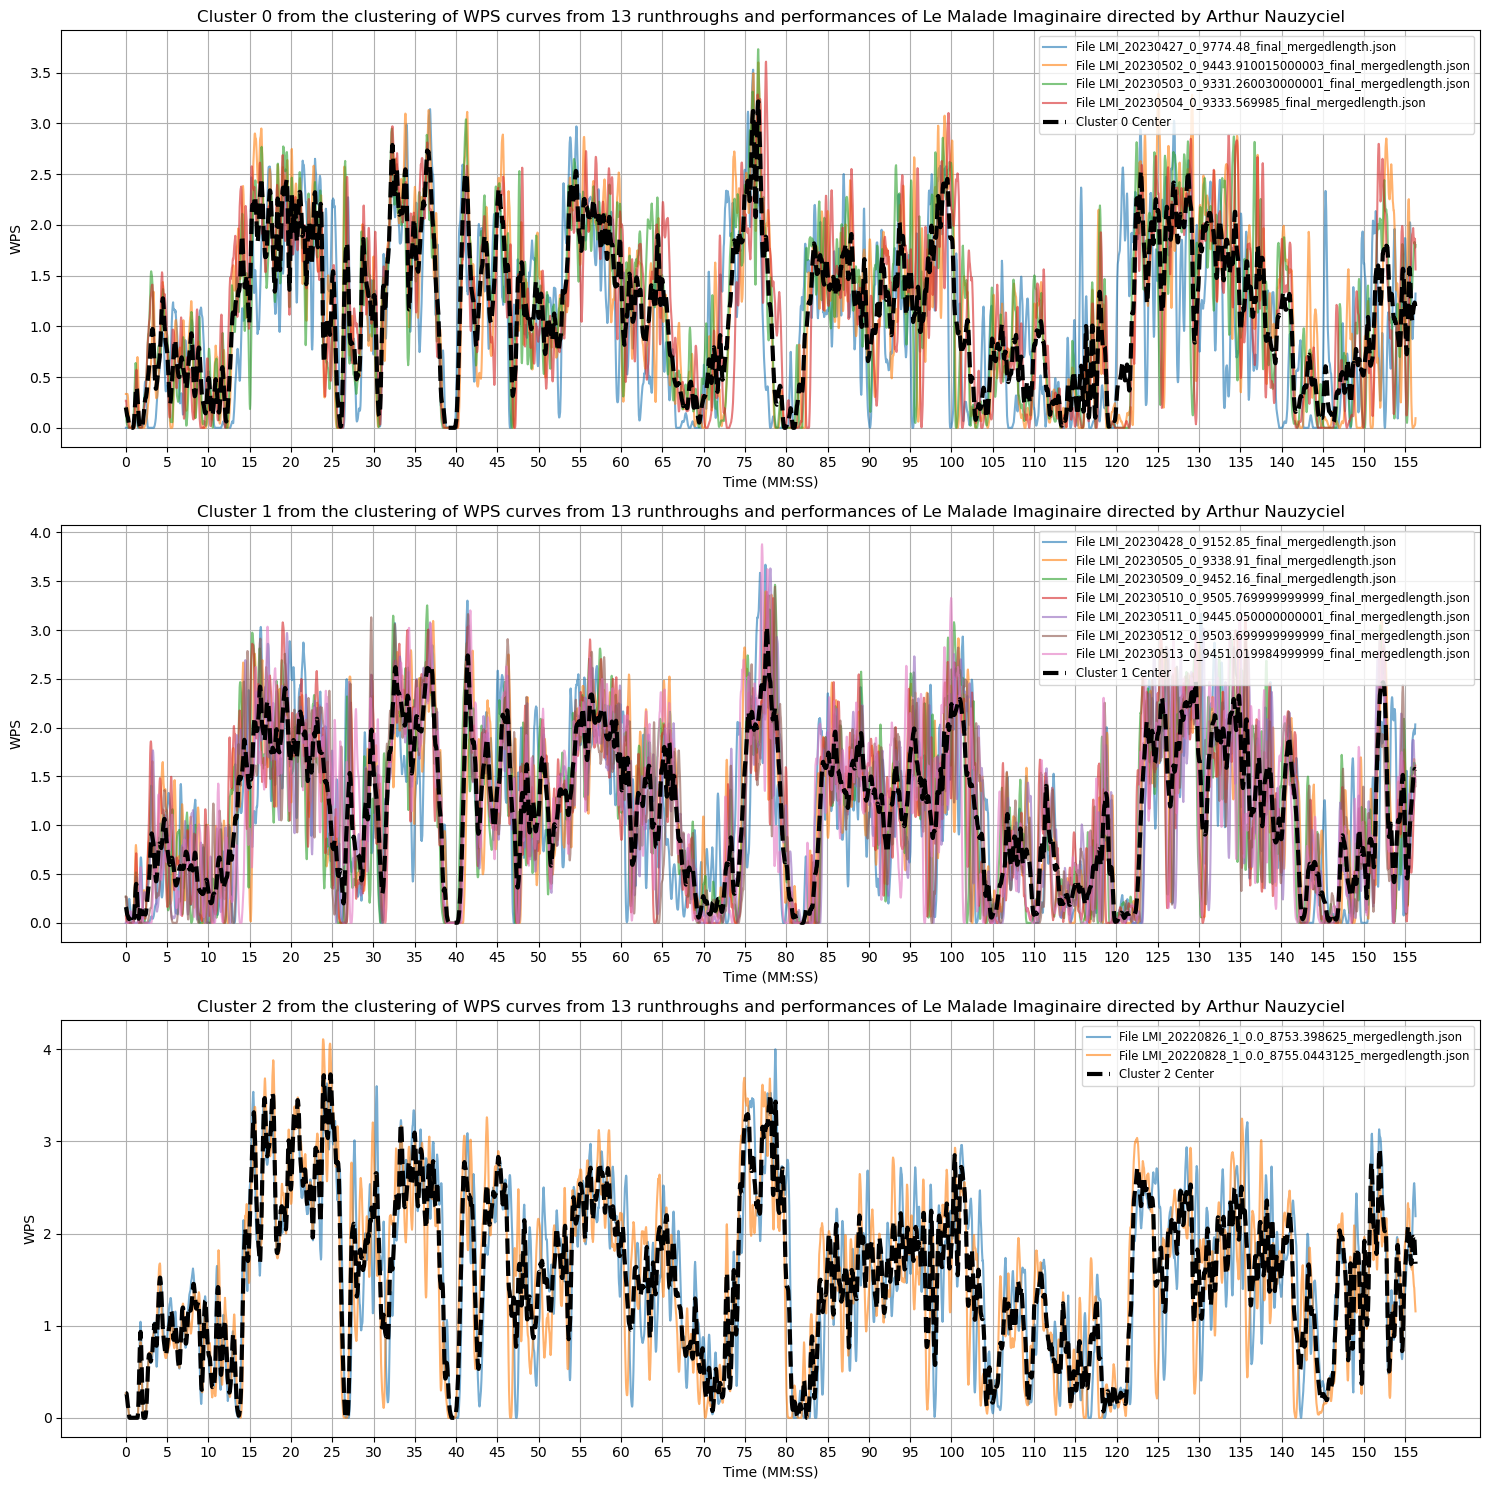

In [29]:
# Choix d'utiliser les données normalisées ou non normalisées
use_normalized = False  # Passez à True pour utiliser les données normalisées

# Sélection des courbes à utiliser
curves_to_plot = processed_curves_normalized if use_normalized else processed_curves

# Si on utilise des données non normalisées, on doit rétablir les centres des clusters à leur échelle d'origine
if not use_normalized:
    # Calculer la moyenne et l'écart-type global sur toutes les courbes (non par courbe)
    overall_mean = np.mean(processed_curves, axis=0)  # Moyenne sur l'axe 0 (au niveau des frames)
    overall_std = np.std(processed_curves, axis=0)    # Écart-type sur l'axe 0 (au niveau des frames)
    
    # Rétablir les centres à l'échelle des courbes non normalisées
    cluster_centers = cluster_centers * overall_std + overall_mean

plt.figure(figsize=(15, 5 * k))  # Taille adaptée au nombre de clusters

for cluster_id in range(k):
    plt.subplot(k, 1, cluster_id + 1)

    # Tracer les courbes appartenant au cluster en cours
    for i, curve in enumerate(curves_to_plot):
        if cluster_labels[i] == cluster_id:
            plt.plot(
                np.linspace(0, len(curve)/fps, common_length),
                curve,  # Utilisation des courbes choisies
                label=f"File {list(all_dps_curves.keys())[i]}",
                alpha=0.6
            )

    # Ajouter le centre du cluster
    plt.plot(
        np.linspace(0, len(curve)/fps, common_length),
        cluster_centers[cluster_id],  # Utilisation des centres potentiellement rétablis
        label=f"Cluster {cluster_id} Center",
        linewidth=3,
        linestyle="--",
        color="black"
    )

    plt.title(f"Cluster {cluster_id} from the clustering of WPS curves from 13 runthroughs and performances of Le Malade Imaginaire directed by Arthur Nauzyciel")
    plt.xlabel("Time (MM:SS)")
    plt.ylabel("WPS (Normalized)" if use_normalized else "WPS")  # Dynamique selon le paramètre
    plt.legend(fontsize="small")
    plt.tight_layout()
    # Ajouter des marqueurs d'axe des x tous les 5 secondes
    time_max = len(cluster_centers[0]) / fps
    x_ticks = np.arange(0, time_max + 1, 5)  # Marqueurs tous les 5 minutes
    plt.xticks(x_ticks)
    plt.grid()


plt.show()


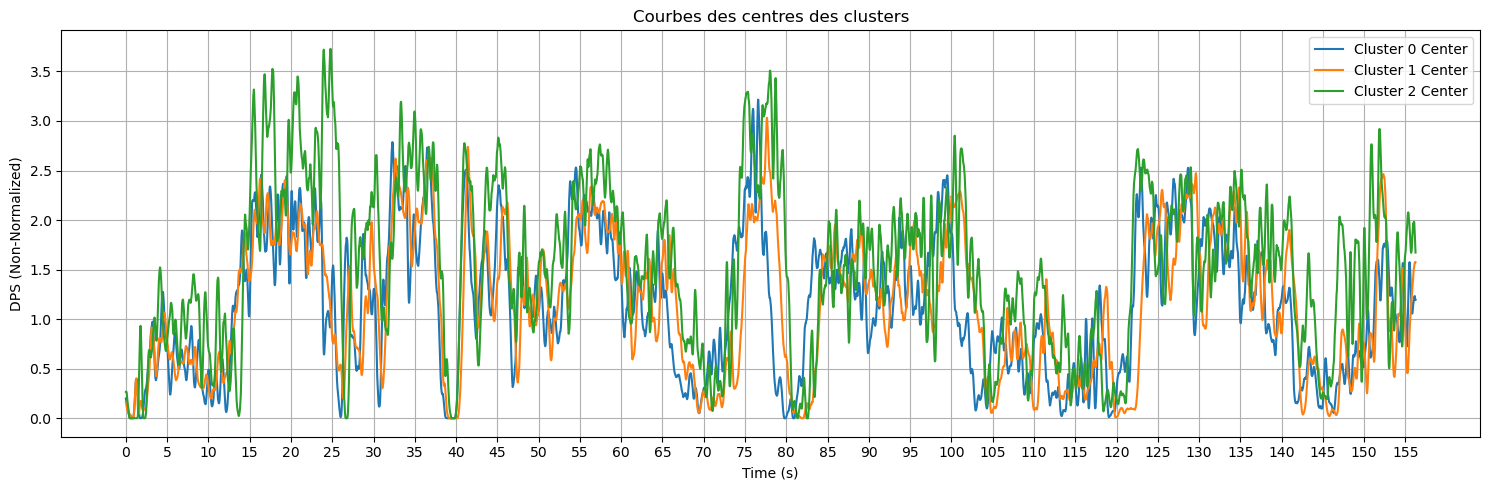

In [30]:
# Visualiser les points de mutation entre les clusters
plt.figure(figsize=(15, 5))

for cluster_id in range(k):
    cluster_center = cluster_centers[cluster_id]
    
    # Tracer la courbe du centre du cluster
    plt.plot(
        np.linspace(0, len(cluster_center) / fps, len(cluster_center)), 
        cluster_center, 
        label=f"Cluster {cluster_id} Center"
    )
    
plt.title("Courbes des centres des clusters")
plt.xlabel("Time (s)")
plt.ylabel("DPS (Non-Normalized)" if not use_normalized else "DPS (Normalized)")
plt.legend()

# Ajouter des marqueurs d'axe des x tous les 5 secondes
time_max = len(cluster_centers[0]) / fps
x_ticks = np.arange(0, time_max + 1, 5)  # Marqueurs tous les 5 minutes
plt.xticks(x_ticks)

plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
Enregistrement des graphiques

In [177]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Répertoire où vous souhaitez enregistrer les images
save_directory = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\Clustering_Images"
os.makedirs(save_directory, exist_ok=True)  # Crée le répertoire si nécessaire

# Paramètre pour déterminer si vous voulez enregistrer l'image
save_plots = True  # Passez à False si vous ne voulez pas enregistrer l'image

# Enregistrement des graphiques
if save_plots:
    # Sauvegarder les courbes des centres des clusters
    save_path_centers = os.path.join(save_directory, "cluster_centers.png")
    plt.figure(figsize=(15, 5))

    for cluster_id in range(k):
        cluster_center = cluster_centers[cluster_id]
        
        # Tracer la courbe du centre du cluster
        plt.plot(np.linspace(0, len(cluster_center) / fps, len(cluster_center)), cluster_center, label=f"Cluster {cluster_id} Center")
    
    plt.title("Courbes des Centres des Clusters")
    plt.xlabel("Time (s)")
    plt.ylabel("DPS (Non-Normalized)" if not use_normalized else "DPS (Normalized)")
    plt.legend()
    plt.tight_layout()

    # Sauvegarder l'image des centres des clusters
    plt.savefig(save_path_centers, bbox_inches='tight', dpi=300)
    print(f"Graphique des centres des clusters enregistré sous : {save_path_centers}")
    plt.close()  # Fermer la figure pour libérer de la mémoire

    # Sauvegarder les courbes des clusters avec leurs centres
    save_path_clusters = os.path.join(save_directory, "clustered_dps_curves.png")
    plt.figure(figsize=(15, 5 * k))  # Taille adaptée au nombre de clusters

    for cluster_id in range(k):
        plt.subplot(k, 1, cluster_id + 1)

        # Tracer les courbes appartenant au cluster en cours
        for i, curve in enumerate(curves_to_plot):
            if cluster_labels[i] == cluster_id:
                plt.plot(
                    np.linspace(0, len(curve)/fps, common_length),
                    curve,  # Utilisation des courbes choisies
                    label=f"File {list(all_dps_curves.keys())[i]}",
                    alpha=0.6
                )

        # Ajouter le centre du cluster
        plt.plot(
            np.linspace(0, len(curve)/fps, common_length),
            cluster_centers[cluster_id],  # Utilisation des centres potentiellement rétablis
            label=f"Cluster {cluster_id} Center",
            linewidth=3,
            linestyle="--",
            color="black"
        )

        plt.title(f"Cluster {cluster_id} from the clustering of WPS curves from 13 runthroughs and performances of Le Malade Imaginaire directed by Arthur Nauzyciel")
        plt.xlabel("Time (MM:SS)")
        plt.ylabel("WPS (Normalized)" if use_normalized else "WPS")  # Dynamique selon le paramètre
        plt.legend(fontsize="small")
        plt.tight_layout()

    # Sauvegarder l'image des courbes des clusters
    plt.savefig(save_path_clusters, bbox_inches='tight', dpi=300)
    print(f"Graphique des courbes des clusters enregistré sous : {save_path_clusters}")
    plt.close()  # Fermer la figure pour libérer de la mémoire


Graphique des centres des clusters enregistré sous : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\Clustering_Images\cluster_centers.png
Graphique des courbes des clusters enregistré sous : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\Clustering_Images\clustered_dps_curves.png


## 6. Clustering de clustering

Dans les prochaines cellules nous allons procéder à une première visualisation via clustering et afficher un graph présentant les trois clusters et un affichant le centre de chacun des clusters

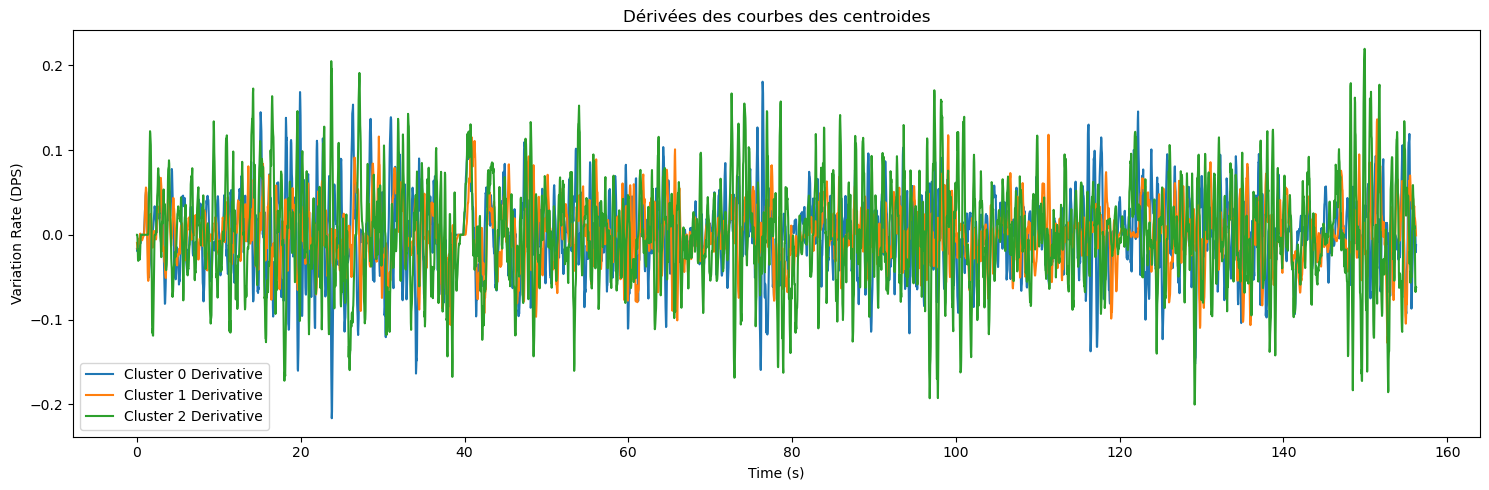

In [32]:
# Calcul des dérivées des courbes des centroides
derivatives = [np.gradient(cluster_center) for cluster_center in cluster_centers]

# Afficher les dérivées
plt.figure(figsize=(15, 5))
for cluster_id, derivative in enumerate(derivatives):
    plt.plot(np.linspace(0, len(derivative) / fps, len(derivative)), 
             derivative, label=f"Cluster {cluster_id} Derivative")
    
plt.title("Dérivées des courbes des centroides")
plt.xlabel("Time (s)")
plt.ylabel("Variation Rate (DPS)")
plt.legend()
plt.tight_layout()
plt.show()


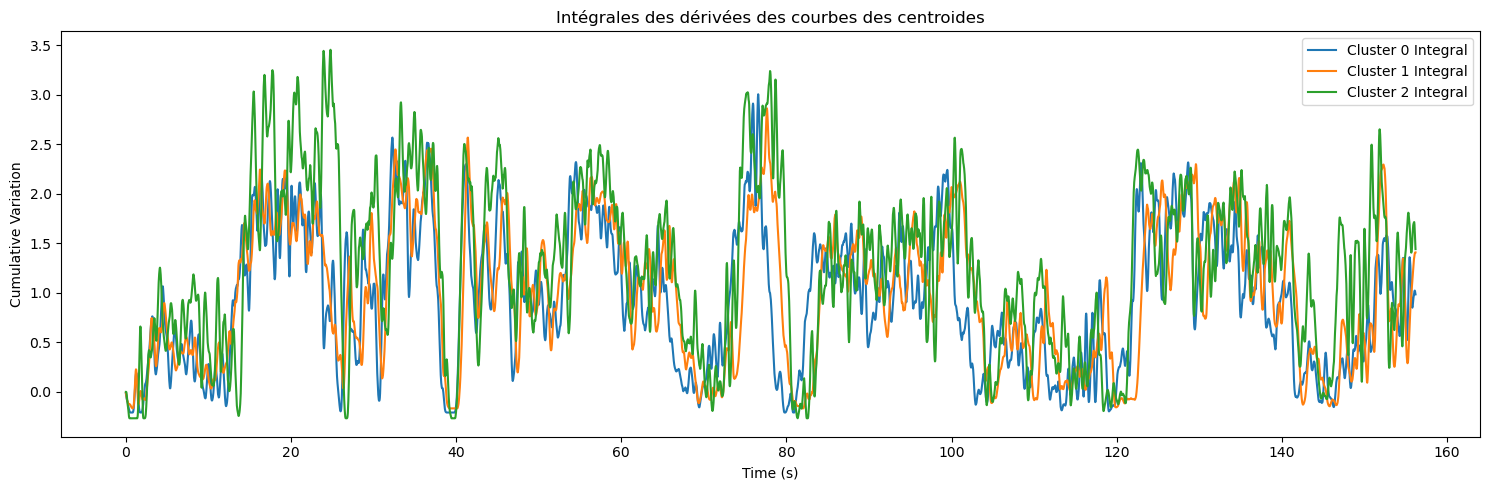

In [33]:
# Calcul des intégrales des dérivées
integrals = [np.cumsum(derivative) for derivative in derivatives]

# Afficher les intégrales
plt.figure(figsize=(15, 5))
for cluster_id, integral in enumerate(integrals):
    plt.plot(np.linspace(0, len(integral) / fps, len(integral)), 
             integral, label=f"Cluster {cluster_id} Integral")
    
plt.title("Intégrales des dérivées des courbes des centroides")
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Variation")
plt.legend()
plt.tight_layout()
plt.show()


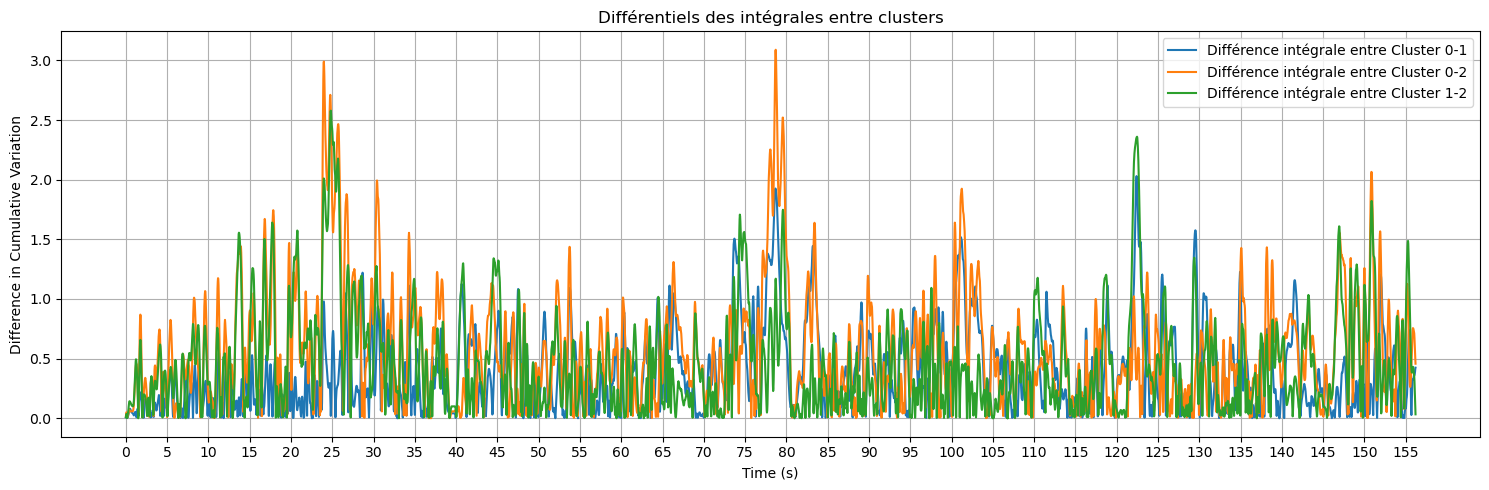

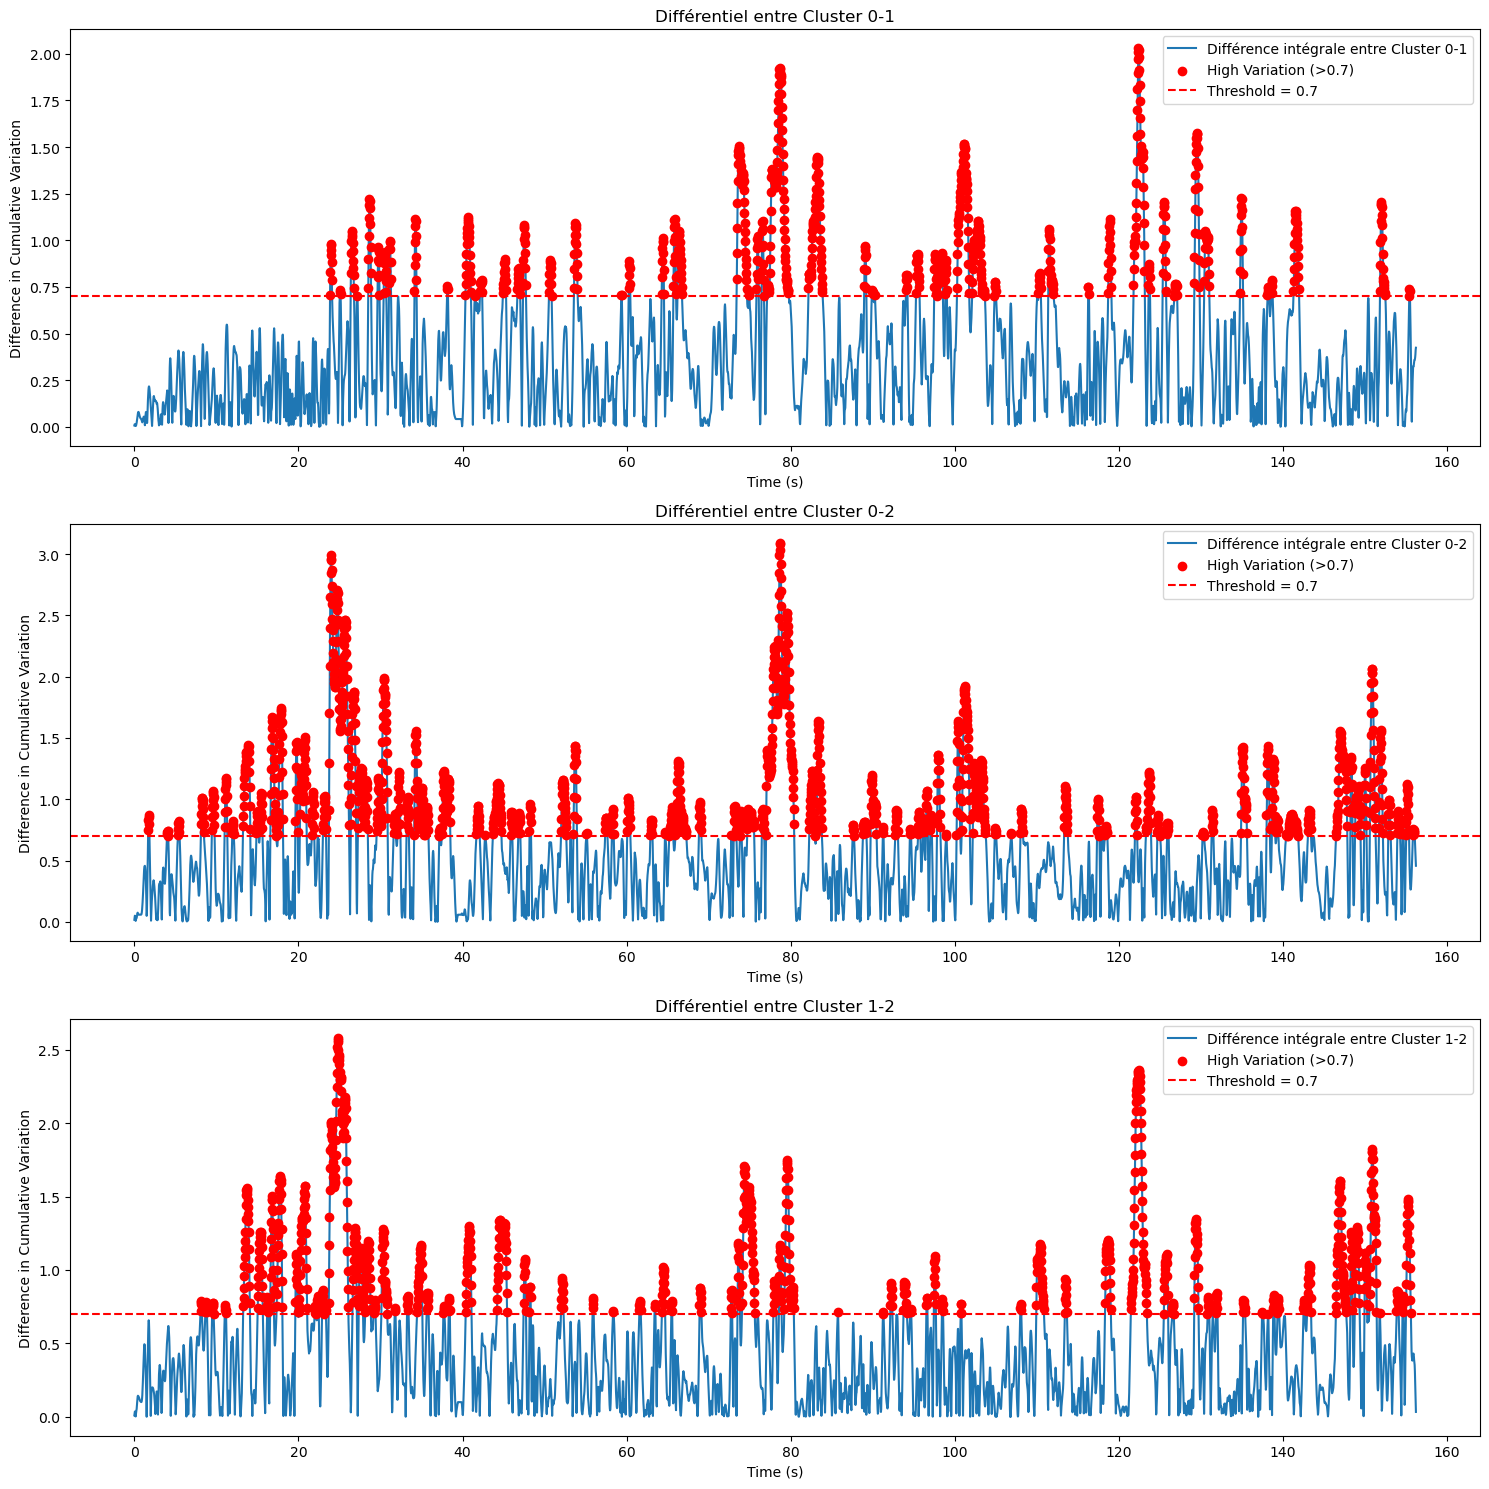

In [34]:
# Définir un seuil pour mettre en évidence les variations importantes
threshold = 0.7  # Ajustez cette valeur selon les données

# Calcul du différentiel des intégrales entre chaque paire de clusters
differentials = {}
for i in range(len(integrals)):
    for j in range(i + 1, len(integrals)):
        differ = np.abs(integrals[i] - integrals[j])
        differentials[f"{i}-{j}"] = differ

# Afficher les différentiels sur un graphe unique
plt.figure(figsize=(15, 5))
for pair, differ in differentials.items():
    plt.plot(np.linspace(0, len(differ) / fps, len(differ)), 
             differ, label=f"Différence intégrale entre Cluster {pair}")

plt.title("Différentiels des intégrales entre clusters")
plt.xlabel("Time (s)")
plt.ylabel("Difference in Cumulative Variation")
plt.legend()
plt.tight_layout()
# Ajouter des marqueurs d'axe des x tous les 5 secondes
time_max = len(cluster_centers[0]) / fps
x_ticks = np.arange(0, time_max + 1, 5)  # Marqueurs tous les 5 minutes
plt.xticks(x_ticks)

plt.grid()
plt.show()

# Afficher chaque différentiel sur un graphe séparé avec le seuil
plt.figure(figsize=(15, 5 * len(differentials)))  # Un graphe par différentiel
for idx, (pair, differ) in enumerate(differentials.items()):
    plt.subplot(len(differentials), 1, idx + 1)
    plt.plot(np.linspace(0, len(differ) / fps, len(differ)), differ, label=f"Différence intégrale entre Cluster {pair}")
    
    # Ajouter les segments qui dépassent le seuil
    high_indices = np.where(differ > threshold)[0]
    plt.scatter(
        np.array(high_indices) / fps,  # Convertir les indices en temps
        [differ[i] for i in high_indices], 
        color='red', 
        label=f"High Variation (>{threshold})", 
        zorder=5
    )
    
    plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")  # Ligne de seuil
    plt.title(f"Différentiel entre Cluster {pair}")
    plt.xlabel("Time (s)")
    plt.ylabel("Difference in Cumulative Variation")
    plt.legend()
plt.tight_layout()

plt.show()


Clés des différentiels : ['0-1', '0-2', '1-2']
Clés des différentiels des différentiels : ['0-1 vs 0-2', '0-1 vs 1-2', '0-2 vs 1-2']
156.25


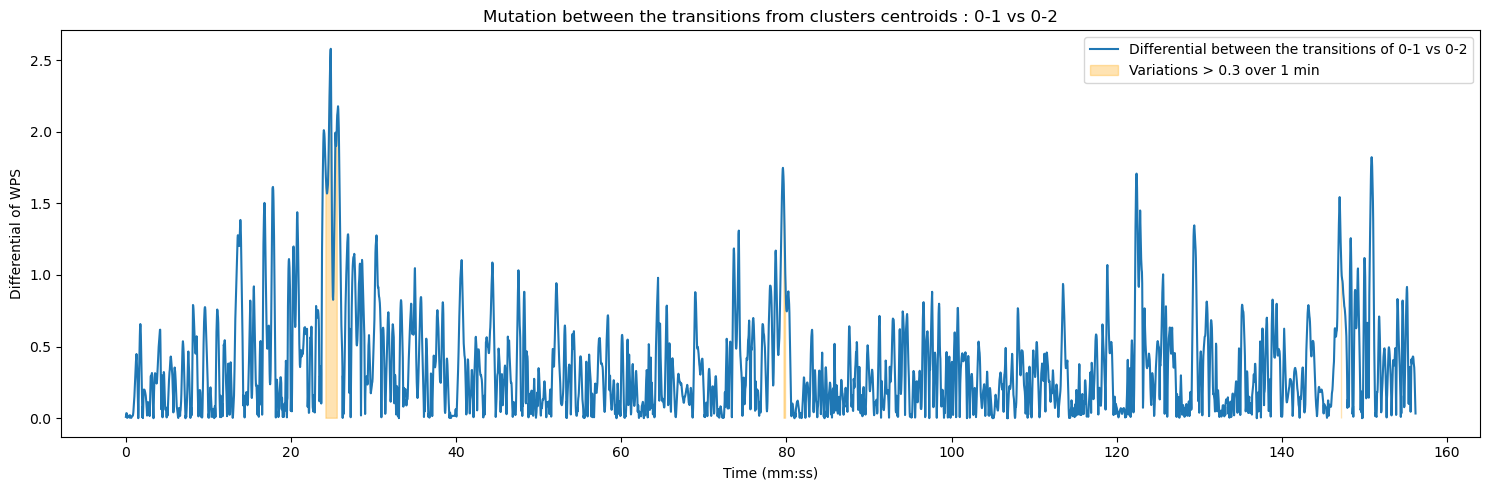

Segments significatifs pour 0-1 vs 0-2 (seuil 0.7 sur 1 minutes) :
- Horaires au format mm.ss :  [(24.21875, 25.625), (79.6875, 79.90625), (147.1875, 147.21875)]


In [35]:
def indices_to_timeranges(valid_segments, fps):
    """
    Convertit un tableau booléen ou une liste d'indices en plages de temps où la condition est remplie.

    Args:
        valid_segments (array-like): Tableau booléen où True indique une condition valide, ou liste d'indices.
        fps (float): Fréquence d'échantillonnage (frames par seconde).

    Returns:
        time_ranges (list of tuples): Liste de plages de temps en secondes (début, fin).
        segment_minutes (list of tuples): Plages converties en minutes.
        segment_seconds (list of tuples): Plages converties en secondes.
    """
    time_ranges = []
    start = None

    for i, is_valid in enumerate(valid_segments):
        if is_valid and start is None:
            start = i
        elif not is_valid and start is not None:
            end = i
            time_ranges.append((start / fps, end / fps))  # Convertir les indices en secondes
            start = None

    if start is not None:
        time_ranges.append((start / fps, len(valid_segments) / fps))

    segment_minutes = [(t[0] // 60, t[1] // 60) for t in time_ranges]
    segment_seconds = [(t[0] % 60, t[1] % 60) for t in time_ranges]

    #print("TIME RANGES")
    #print(time_ranges)
    #print("SEG MIN")
    #print(segment_minutes)
    #print("SEG SEC")
    #print(segment_seconds)

    return time_ranges, segment_minutes, segment_seconds
'''-------------------------'''
# Calcul des différentiels
differentials = {}
for i in range(len(integrals)):
    for j in range(i + 1, len(integrals)):
        differ = np.abs(integrals[i] - integrals[j])
        differentials[f"{i}-{j}"] = differ

# Vérification des différentiels
print("Clés des différentiels :", list(differentials.keys()))

# Calcul des différentiels des différentiels
differentials_of_differentials = {}
diff_keys = list(differentials.keys())

for i in range(len(diff_keys)):
    for j in range(i + 1, len(diff_keys)):
        key1, key2 = diff_keys[i], diff_keys[j]
        differ1, differ2 = differentials[key1], differentials[key2]
        differ_of_differ = np.abs(differ1 - differ2)
        differentials_of_differentials[f"{key1} vs {key2}"] = differ_of_differ

# Vérification des différentiels des différentiels
print("Clés des différentiels des différentiels :", list(differentials_of_differentials.keys()))

# Utilisation d'une clé valide
if single_graph_key not in differentials_of_differentials:
    print(f"Clé '{single_graph_key}' introuvable. Utilisation d'une clé par défaut.")
    single_graph_key = list(differentials_of_differentials.keys())[0]

# Traçage
plot_differentials_with_segments(key=single_graph_key)



156.25


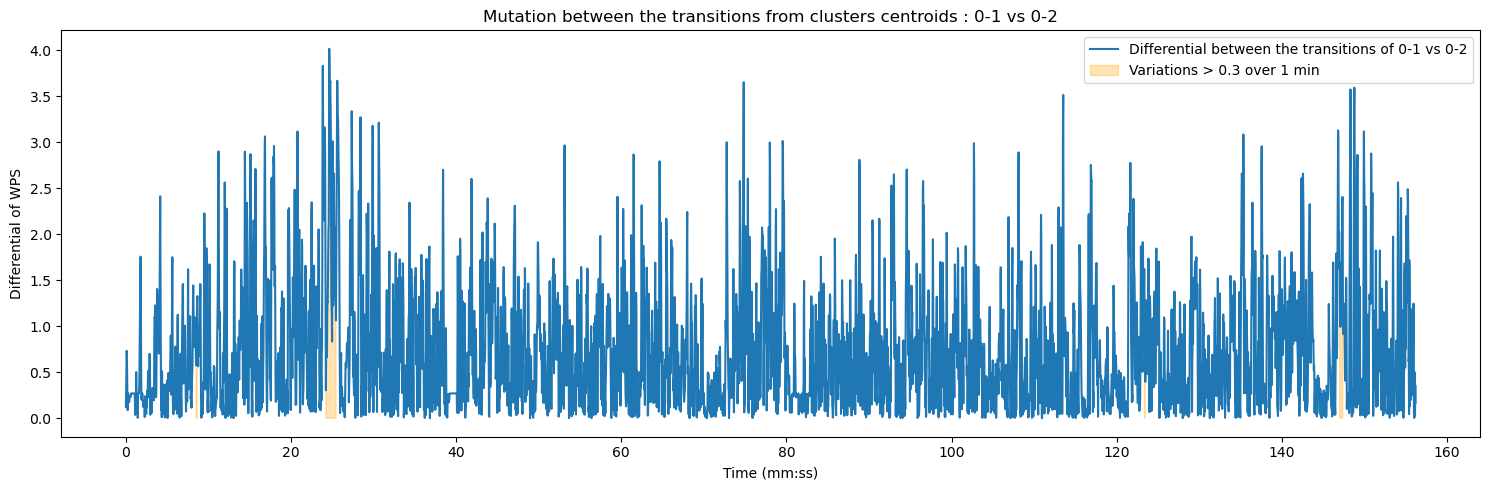

Segments significatifs pour 0-1 vs 0-2 (seuil 0.3 sur 1 minutes) :
- Horaires au format mm.ss :  [(8.5, 8.65625), (24.21875, 25.46875), (123.34375, 123.46875), (146.96875, 147.375)]


In [23]:
def find_constant_segments_over_threshold(data, threshold, window_size):
    """
    Trouve les segments de `data` où les valeurs dépassent `threshold` 
    sur une période continue d'au moins `window_size`.
    """
    # Identifie les points au-dessus du seuil
    above_threshold = data > threshold
    
    # Crée un masque booléen avec des fenêtres glissantes
    valid_segments = np.convolve(above_threshold, np.ones(window_size, dtype=int), mode='same') >= window_size
    
    return valid_segments

# Fonction d'affichage des différentiels avec ajout des segments significatifs
display_all_graphs = False  # Mettre False pour n'afficher qu'un seul graphe
single_graph_key = "0-1 vs 0-2"

# Définir les nouveaux seuils et tailles de fenêtre
threshold = 0.3  # Seuil de différence (par exemple, 0.5)
time_window = 1  # Fenêtre temporelle en minutes (par exemple, 0.5 minutes)
window_size = int(time_window * fps)  # Convertir la fenêtre en nombre d'échantillons

label_for_significant_segments = f"Variations > {threshold} over {time_window} min"

def plot_differentials_with_segments(key=None):
    curves_to_plot = [key] if key else differentials_of_differentials.keys()
    
    for curve_key in curves_to_plot:
        differ_of_differ = differentials_of_differentials[curve_key]
        valid_segments = find_constant_segments_over_threshold(differ_of_differ, threshold, window_size)
        time_ranges, segment_minutes, segment_seconds = indices_to_timeranges(valid_segments, fps)

        
        # Graphique
        plt.figure(figsize=(15, 5))
        time_axis = np.linspace(0, len(differ_of_differ) / fps, len(differ_of_differ))

        print(time_axis[4999])
        
        plt.plot(time_axis, differ_of_differ, label=f"Differential between the transitions of {curve_key}")
        plt.fill_between(time_axis, 0, differ_of_differ, where=valid_segments, 
                 color='orange', alpha=0.3, label=label_for_significant_segments)

        #plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
        plt.title(f"Mutation between the transitions from clusters centroids : {curve_key}")
        plt.xlabel("Time (mm:ss)")
        plt.ylabel("Differential of WPS")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Inspection des segments
        print(f"Segments significatifs pour {curve_key} (seuil {threshold} sur {time_window} minutes) :")     
        # Affichage des horaires au format mm:ss

        time_ranges_mmss = []
        for start, end in segment_seconds:
            start_mmss = f"{int(start):02}.{int((start % 1) * 60):02}"
            end_mmss = f"{int(end):02}.{int((end % 1) * 60):02}"
            
            time_ranges_mmss.append((start_mmss, end_mmss))
        
        #time_ranges_mmss = [
        #    (f"{int(start):02}.{int((start % 1) * 60):02}", f"{int(end):02}.{int((end % 1) * 60):02}")
        #    for start, end in segment_seconds
        #]
        
        print("- Horaires au format mm.ss : ", time_ranges)  # Horaires en mm:ss pour la lisibilité

# Utilisation
if display_all_graphs:
    plot_differentials_with_segments()
else:
    plot_differentials_with_segments(key=single_graph_key)


## 7. Enregistrement

On vérifie à quoi correspondent les zones de mutation en retrouvant les timers de chacune des vidéos et non plus les timers normalisés

In [ ]:
enregistrement

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Répertoire de sauvegarde
save_directory = r"C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\Clustering_Images"

# Fonction d'affichage et d'enregistrement des différentiels avec ajout des segments significatifs
def plot_differentials_with_segments(key=None):
    curves_to_plot = [key] if key else differentials_of_differentials.keys()
    
    for curve_key in curves_to_plot:
        differ_of_differ = differentials_of_differentials[curve_key]
        valid_segments = find_constant_segments_over_threshold(differ_of_differ, threshold, window_size)
        time_ranges, segment_minutes, segment_seconds = indices_to_timeranges(valid_segments, fps)
        
        # Graphique
        plt.figure(figsize=(15, 5))
        time_axis = np.linspace(0, len(differ_of_differ) / fps, len(differ_of_differ))
        plt.plot(time_axis, differ_of_differ, label=f"Differential between the transitions of {curve_key}")
        plt.fill_between(time_axis, 0, differ_of_differ, where=valid_segments, 
                         color='orange', alpha=0.3, label=label_for_significant_segments)

        plt.title(f"Mutation between the transitions from clusters centroids : {curve_key}")
        plt.xlabel("Time (mm:ss)")
        plt.ylabel("Differential of WPS")
        plt.legend()
        plt.tight_layout()
        
        # Enregistrer le graphique
        # Créer un nom de fichier basé sur la clé de la courbe
        filename = f"{curve_key.replace('/', '-')}.png"  # Remplace les '/' pour éviter des erreurs de nom de fichier
        save_path = os.path.join(save_directory, filename)
        
        # Vérifier si le répertoire existe, sinon le créer
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        # Sauvegarder le graphique
        plt.savefig(save_path)
        print(f"Graph saved at {save_path}")

        # Fermer la figure pour libérer la mémoire
        plt.close()

        # Inspection des segments
        print(f"Segments significatifs pour {curve_key} (seuil {threshold} sur {time_window} minutes) :")
        # Affichage des horaires au format mm:ss
        time_ranges_mmss = [
            (f"{int(start):02}.{int((start % 1) * 60):02}", f"{int(end):02}.{int((end % 1) * 60):02}")
            for start, end in segment_seconds
        ]
        
        print("- Horaires au format mm.ss : ", time_ranges_mmss)  # Horaires en mm:ss pour la lisibilité

# Utilisation
if display_all_graphs:
    plot_differentials_with_segments()
else:
    plot_differentials_with_segments(key=single_graph_key)


NameError: name 'display_all_graphs' is not defined

## 8. Vérification

On vérifie à quoi correspondent les zones de mutation en retrouvant les timers de chacune des vidéos et non plus les timers normalisés

In [78]:
import re

# Fonction pour extraire la durée réelle depuis le nom du fichier
def extract_duration_from_filename(filename):
    """
    Extrait la durée réelle (en secondes) depuis le nom du fichier.
    """
    match = re.search(r'_(\d+\.\d+)_mergedlength\.json|_(\d+\.\d+)_final_mergedlength\.json', filename)
    if match:
        return float(match.group(1) or match.group(2))
    else:
        raise ValueError(f"Impossible d'extraire la durée pour le fichier : {filename}")

# Fonction pour afficher la durée totale en mm:ss
def display_file_duration(filename):
    """
    Affiche la durée totale du fichier en `mm:ss`.
    """
    total_duration_seconds = extract_duration_from_filename(filename)
    minutes = int(total_duration_seconds // 60)
    seconds = int(total_duration_seconds % 60)
    print(f"Durée totale du fichier : {minutes:02}:{seconds:02} ({total_duration_seconds:.2f} secondes)")
    return total_duration_seconds

# Fonction pour mapper les plages horaires vers l'échelle réelle
def map_time_ranges_to_original_scale(time_ranges_mmss, total_duration_seconds, common_length):
    """
    Mappe les plages horaires depuis l'échelle interpolée vers l'échelle réelle.

    Args:
        time_ranges_mmss (list of tuples): Plages horaires interpolées en format mm.ss (début, fin).
        total_duration_seconds (float): Durée réelle du fichier.
        common_length (int): Longueur interpolée des courbes.

    Returns:
        real_time_ranges (list of tuples): Plages horaires mappées en secondes réelles.
    """
    real_time_ranges = []
    for start_mmss, end_mmss in time_ranges_mmss:
        #start_minutes, start_seconds = map(float, start_mmss.split('.'))
        #end_minutes, end_seconds = map(float, end_mmss.split('.'))

        #print("BEFORE TRANS")
        #print(start_mmss, end_mmss)
        
        #print("NORMED")
        #print(start_minutes, start_seconds)
        #print(end_minutes, end_seconds)
        
        #start_interpolated = (start_minutes * 60 + start_seconds) / common_length
        #end_interpolated = (end_minutes * 60 + end_seconds) / common_length

        start_interpolated = start_mmss / common_length
        end_interpolated = end_mmss / common_length
        
        real_start = start_interpolated * (total_duration_seconds / 60)
        real_end = end_interpolated * (total_duration_seconds / 60)

        real_time_ranges.append((real_start, real_end))
    return real_time_ranges

# Fonction principale pour afficher les segments significatifs adaptés à la durée réelle
def display_mapped_segments(filename, time_ranges_mmss, common_length):
    """
    Affiche les plages horaires significatives adaptées à la durée réelle du fichier.

    Args:
        filename (str): Nom du fichier contenant la durée.
        time_ranges_mmss (list of tuples): Plages horaires en format mm.ss.
        common_length (int): Longueur interpolée des courbes.
    """
    # Obtenir et afficher la durée totale du fichier
    total_duration_seconds = display_file_duration(filename)

    # Mapper les plages horaires vers l'échelle réelle
    real_time_ranges = map_time_ranges_to_original_scale(time_ranges_mmss, total_duration_seconds, common_length)

    # Affichage des segments significatifs mappés
    print("\nSegments significatifs adaptés à la durée réelle :")
    for real_start, real_end in real_time_ranges:
        
        start_minutes = int(real_start)
        start_seconds = int((real_start - start_minutes) * 60)

        end_minutes = int(real_end)
        end_seconds = int((real_end - end_minutes) * 60)

        print(f"{start_minutes}:{start_seconds} ({real_start}) - {end_minutes}:{end_seconds} ({real_end})")


        #start_mmss = f"{int(real_start // 60):02}:{int(real_start % 60):02}"
        #end_mmss = f"{int(real_end // 60):02}:{int(real_end % 60):02}"
        #print(f"De {start_mmss} ({real_start:.2f}s) à {end_mmss} ({real_end:.2f}s)")
# Traitement de tous les fichiers dans analysis_files
def process_all_files(analysis_files, time_ranges_mmss, common_length):
    """
    Traite tous les fichiers listés dans analysis_files et affiche les segments significatifs pour chacun.

    Args:
        analysis_files (list of str): Liste des chemins des fichiers d'analyse.
        time_ranges_mmss (list of tuples): Plages horaires interpolées (début, fin).
        common_length (float): Longueur interpolée des courbes.
    """
    for filename in analysis_files:
        print(f"\nTraitement du fichier : {filename}")
        try:
            display_mapped_segments(filename, time_ranges_mmss, common_length)
        except Exception as e:
            print(f"Erreur lors du traitement du fichier {filename} : {e}")

# Exemple d'utilisation
filename = "LMI_20220828_1_0.0_8755.0443125_mergedlength.json"
common_length = 166.66666666666666  # Longueur interpolée des courbes (exemple)
#time_ranges_mmss = [("18.2", "19.0"), ("24.966666666666665", "27.566666666666666"), ("29.9", "29.933333333333334"), ("32.43333333333333", "32.63333333333333"), ("78.7", "79.13333333333334"), ("83.96666666666667", "85.36666666666666"), ("156.36666666666667", "157.9"), ("160.3", "161.36666666666667")]  # Plages horaires interpolées (exemple)
time_ranges_mmss = [(18.2, 19.0), (24.966666666666665, 27.566666666666666), (29.9, 29.933333333333334), (32.43333333333333, 32.63333333333333), (78.7, 79.13333333333334), (83.96666666666667, 85.36666666666666), (156.36666666666667, 157.9), (160.3, 161.36666666666667)]


process_all_files(analysis_files, time_ranges_mmss, common_length)



Traitement du fichier : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\input\LMI_20220826_1_0.0_8753.398625_mergedlength.json
Durée totale du fichier : 145:53 (8753.40 secondes)

Segments significatifs adaptés à la durée réelle :
15:55 (15.9311854975) - 16:37 (16.6314573875)
21:51 (21.85431856708333) - 24:7 (24.130202209583334)
26:10 (26.17266188875) - 26:12 (26.201839884166667)
28:23 (28.390189540416664) - 28:33 (28.565257512916663)
68:53 (68.88924717875) - 69:16 (69.26856111916666)
73:29 (73.49937045458333) - 74:43 (74.72484626208333)
136:52 (136.87397649958334) - 138:12 (138.21616428875)
140:19 (140.31697995875) - 141:15 (141.25067581208333)

Traitement du fichier : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\input\LMI_20220828_1_0.0_8755.0443125_mergedlength.json
Durée totale du fichier : 145:55 (8755.04 secondes)

Segments significatifs adaptés à la durée réelle :
15:56 (15.934180648750003) - 16:38 (16.63458419375)
21:51 (21.858427300208334) - 24:8 (24.13

In [83]:
import csv
import os

# Fonction pour écrire les données dans un fichier CSV
def export_to_csv(output_file, results):
    """
    Exporte les segments significatifs adaptés à la durée réelle dans un fichier CSV.

    Args:
        output_file (str): Nom du fichier CSV de sortie.
        results (list of dict): Liste contenant les résultats pour chaque fichier.
    """
    # Créer ou ouvrir le fichier en mode écriture
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Écrire l'en-tête
        writer.writerow(["Filename", "Total Duration (mm:ss)", "Segments (mm:ss)"])
        
        # Écrire les résultats
        for result in results:
            writer.writerow([
                result["filename"],
                result["total_duration"],
                "; ".join(result["segments"])  # Plages horaires concaténées
            ])
    print(f"Données exportées avec succès dans {output_file}")

# Fonction principale pour traiter et exporter les fichiers
def process_and_export_files(analysis_files, time_ranges_mmss, common_length, output_csv=None):
    """
    Traite tous les fichiers, affiche les segments significatifs, et exporte les résultats en CSV.

    Args:
        analysis_files (list of str): Liste des chemins des fichiers d'analyse.
        time_ranges_mmss (list of tuples): Plages horaires interpolées (début, fin).
        common_length (float): Longueur interpolée des courbes.
        output_csv (str): Nom du fichier CSV pour l'exportation (optionnel).
    """
    results = []
    
    for filename in analysis_files:
        print(f"\nTraitement du fichier : {filename}")
        try:
            # Obtenir la durée totale
            total_duration_seconds = display_file_duration(filename)
            
            # Mapper les plages horaires vers l'échelle réelle
            real_time_ranges = map_time_ranges_to_original_scale(time_ranges_mmss, total_duration_seconds, common_length)
            
            # Formater les segments pour l'affichage
            segments_formatted = []
            for real_start, real_end in real_time_ranges:
                start_minutes = int(real_start)
                start_seconds = int((real_start - start_minutes) * 60)
                end_minutes = int(real_end)
                end_seconds = int((real_end - end_minutes) * 60)
                segments_formatted.append(f"{start_minutes:02}:{start_seconds:02} - {end_minutes:02}:{end_seconds:02}")
            
            # Ajouter au résultat
            results.append({
                "filename": os.path.basename(filename),
                "total_duration": f"{int(total_duration_seconds // 60):02}:{int(total_duration_seconds % 60):02}",
                "segments": segments_formatted
            })
            
            # Afficher les segments
            print("\nSegments significatifs adaptés à la durée réelle :")
            for segment in segments_formatted:
                print(segment)

        except Exception as e:
            print(f"Erreur lors du traitement du fichier {filename} : {e}")
    
    # Exporter les résultats si un fichier CSV est spécifié
    if output_csv:
        export_to_csv(output_csv, results)
        print(f"Fichier exporté à : {os.path.abspath(output_csv)}")

#output_csv = "significant_segments.csv"  # Nom du fichier CSV de sortie
#output_csv = r"C:\chemin\vers\mon\repertoire\significant_segments.csv"
process_and_export_files(analysis_files, time_ranges_mmss, common_length, output_csv=output_csv)




Traitement du fichier : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\input\LMI_20220826_1_0.0_8753.398625_mergedlength.json
Durée totale du fichier : 145:53 (8753.40 secondes)

Segments significatifs adaptés à la durée réelle :
15:55 - 16:37
21:51 - 24:07
26:10 - 26:12
28:23 - 28:33
68:53 - 69:16
73:29 - 74:43
136:52 - 138:12
140:19 - 141:15

Traitement du fichier : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\input\LMI_20220828_1_0.0_8755.0443125_mergedlength.json
Durée totale du fichier : 145:55 (8755.04 secondes)

Segments significatifs adaptés à la durée réelle :
15:56 - 16:38
21:51 - 24:08
26:10 - 26:12
28:23 - 28:34
68:54 - 69:16
73:30 - 74:44
136:53 - 138:14
140:20 - 141:16

Traitement du fichier : C:\Users\theoh\Documents\Fac\Thèse\Donnees\DPS_LMI\Fusion\input\LMI_20230427_0_9774.48_final_mergedlength.json
Durée totale du fichier : 162:54 (9774.48 secondes)

Segments significatifs adaptés à la durée réelle :
17:47 - 18:34
24:24 - 26:56
29:13 - 29:15
3

## 4. Export to CSV

Now we can take this data, and export it to a csv file to use later. First lets set the output location.

In [8]:
# Give a path to a folder to output the results:
PROCESS_OUTPUT = os.path.join(os.path.abspath('../../..'), "output")

# Create folder if needed:
if os.path.isdir(PROCESS_OUTPUT) == False:
    os.makedirs(PROCESS_OUTPUT)

We can use the dps `numpy_to_csv` function to easily export the results.

In [9]:
'''dps.numpy_to_csv(
    os.path.join(PROCESS_OUTPUT, os.path.splitext(os.path.basename(analysis_files[0]))[0] + ".csv"), [
        {"header" : "Raw silence/spoken", "array" : speech_recognition.raw_curve[0]},
        {"header" : "Raw silence/word", "array" : speech_recognition.raw_curve[1]},
        {"header" : "DPS Feature Curve", "array" : dps_curve}
    ]
)'''

In [209]:
# Parcourir chaque fichier JSON dans la liste
for json_file in analysis_files:
    # Charger le fichier JSON dans dps.SpeechAnalysis
    speech_recognition = dps.SpeechAnalysis(json_file, fps=32)
    
    # Calculer les courbes DPS pour chaque combinaison de paramètres
    parameter_sets = [
        {"name": "W60S", "window_size": 1920, "hop_size": 20},
        {"name": "W15S", "window_size": 480, "hop_size": 10},
        {"name": "W3S", "window_size": 96, "hop_size": 4},
        {"name": "W1S", "window_size": 32, "hop_size": 4}
    ]

    csv_columns = [
        {"header": "Raw silence/spoken", "array": speech_recognition.raw_curve[0]},
        {"header": "Raw silence/word", "array": speech_recognition.raw_curve[1]},
    ]
    
    for params in parameter_sets:
        dps_curve = speech_recognition.get_dps_feature_curve(params["window_size"], params["hop_size"])
        header = f"DPS Curve ({params['name']})"
        csv_columns.append({"header": header, "array": dps_curve})
    
    # Enregistrer chaque fichier CSV avec un nom unique basé sur le JSON traité
    output_csv_path = os.path.join(
        PROCESS_OUTPUT,
        os.path.splitext(os.path.basename(json_file))[0] + "_dps_curves.csv"
    )
    dps.numpy_to_csv(output_csv_path, csv_columns)
    
    print(f"Processed and saved: {output_csv_path}")


Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_2005V2_1_0.0_9023.6373125_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_2005_1_0.0_9355.6266875_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_20220621_1_1_0.0_5020.0043125_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_20220826_1_0.0_8753.398625_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_20220828_1_0.0_8755.0443125_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_20230427_0_9774.48_final_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_20230428_0_9152.85_final_mergedlength_dps_curves.csv
Processed and saved: C:\Users\theoh\Documents\Repo\ml-notebooks\output\LMI_20230502_0_9443.910